#**Home Loan Project: Joana Coyle**

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Objective: Create a model that predicts whether or not an applicant will be able to repay a loan using historical data (binary classification).

#**Step 1: DATA PREPROCESSING:**

###I- Import Required Libraries, Collect & Load Data, Inspect Dataset, and Create a Safe Backup Copy:

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from pathlib import Path
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
DATA_PATH = Path("/content/drive/MyDrive/data sets /loan_data (1).csv")

df = pd.read_csv(DATA_PATH)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
df_original = df.copy()

In [74]:
df.shape

(307511, 122)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [76]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

###II - Data Cleaning:

1) Check for Duplicates

In [77]:
duplicate_rows = df.duplicated()
print("Duplicate Rows:")
print(duplicate_rows.sum())

Duplicate Rows:
0


2) Handle Missing Values:  
 • Drop rows belonging to columns with < 5% missing.  
 • Drop columns with > 30% missing.


In [78]:
df.isna().sum()

,0
SK_ID_CURR,0
TARGET,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
...,...
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519


In [79]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = missing_percent.reset_index()
missing_df.columns = ['Column', 'Missing (%)']
print(missing_df)

                         Column  Missing (%)
0                    SK_ID_CURR     0.000000
1                        TARGET     0.000000
2            NAME_CONTRACT_TYPE     0.000000
3                   CODE_GENDER     0.000000
4                  FLAG_OWN_CAR     0.000000
..                          ...          ...
117   AMT_REQ_CREDIT_BUREAU_DAY    13.501631
118  AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
119   AMT_REQ_CREDIT_BUREAU_MON    13.501631
120   AMT_REQ_CREDIT_BUREAU_QRT    13.501631
121  AMT_REQ_CREDIT_BUREAU_YEAR    13.501631

[122 rows x 2 columns]


In [80]:
low_missing_cols = missing_percent[(missing_percent > 0) & (missing_percent < 5)].index
high_missing_cols = missing_percent[missing_percent > 30].index

print("🔹Columns with <5% missing (drop rows):")
print(low_missing_cols.tolist())

print("\n🔹Columns with >30% missing (drop columns):")
print(high_missing_cols.tolist())

🔹Columns with <5% missing (drop rows):
['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']

🔹Columns with >30% missing (drop columns):
['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_

In [81]:
df = df.dropna(subset=low_missing_cols)

df = df.drop(columns=high_missing_cols)

print("✅ Cleaned dataset shape:", df.shape)

✅ Cleaned dataset shape: (304531, 72)


3) Check if any columns are in date format

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 304531 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   304531 non-null  int64  
 1   TARGET                       304531 non-null  int64  
 2   NAME_CONTRACT_TYPE           304531 non-null  object 
 3   CODE_GENDER                  304531 non-null  object 
 4   FLAG_OWN_CAR                 304531 non-null  object 
 5   FLAG_OWN_REALTY              304531 non-null  object 
 6   CNT_CHILDREN                 304531 non-null  int64  
 7   AMT_INCOME_TOTAL             304531 non-null  float64
 8   AMT_CREDIT                   304531 non-null  float64
 9   AMT_ANNUITY                  304531 non-null  float64
 10  AMT_GOODS_PRICE              304531 non-null  float64
 11  NAME_TYPE_SUITE              304531 non-null  object 
 12  NAME_INCOME_TYPE             304531 non-null  object 
 13  NAME

In [83]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(col)
        print(df[col].head(3))

NAME_CONTRACT_TYPE
0         Cash loans
1         Cash loans
2    Revolving loans
Name: NAME_CONTRACT_TYPE, dtype: object
CODE_GENDER
0    M
1    F
2    M
Name: CODE_GENDER, dtype: object
FLAG_OWN_CAR
0    N
1    N
2    Y
Name: FLAG_OWN_CAR, dtype: object
FLAG_OWN_REALTY
0    Y
1    N
2    Y
Name: FLAG_OWN_REALTY, dtype: object
NAME_TYPE_SUITE
0    Unaccompanied
1           Family
2    Unaccompanied
Name: NAME_TYPE_SUITE, dtype: object
NAME_INCOME_TYPE
0          Working
1    State servant
2          Working
Name: NAME_INCOME_TYPE, dtype: object
NAME_EDUCATION_TYPE
0    Secondary / secondary special
1                 Higher education
2    Secondary / secondary special
Name: NAME_EDUCATION_TYPE, dtype: object
NAME_FAMILY_STATUS
0    Single / not married
1                 Married
2    Single / not married
Name: NAME_FAMILY_STATUS, dtype: object
NAME_HOUSING_TYPE
0    House / apartment
1    House / apartment
2    House / apartment
Name: NAME_HOUSING_TYPE, dtype: object
WEEKDAY_APPR_PROCES

###III - Exploratory Data Analysis (EDA):

1) Binning and Feature Transformation

#####* Convert & Bin Columns (DAYS_BIRTH → AGE_YEARS, DAYS_EMPLOYED → EMPLOYED_YEARS)

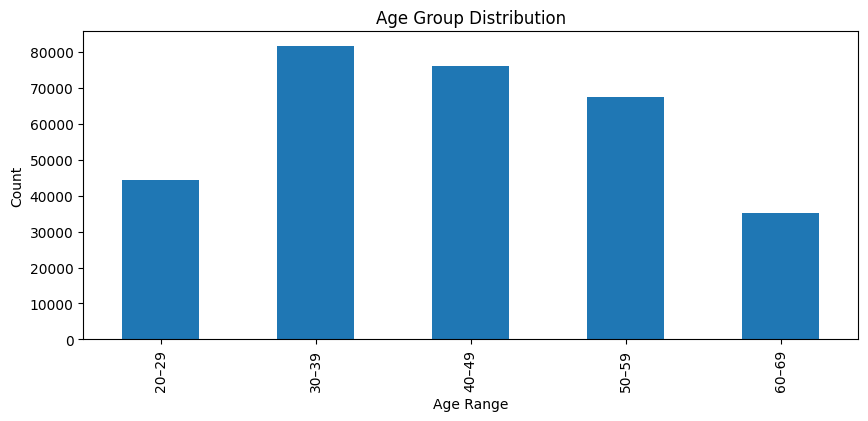

In [84]:
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) / 365

age_bins = [20, 30, 40, 50, 60, 70]
age_labels = ['20–29', '30–39', '40–49', '50–59', '60–69']

df['AGE_GROUP'] = pd.cut(df['AGE_YEARS'], bins=age_bins, labels=age_labels)

plt.figure(figsize=(10,4))
df['AGE_GROUP'].value_counts().sort_index().plot(kind='bar')
plt.title('Age Group Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.show()

   AGE_YEARS AGE_GROUP  EMPLOYED_YEARS EMPLOYMENT_GROUP
0  25.920548     20–29        1.745205             1–3y
1  45.931507     40–49        3.254795             3–5y
2  52.180822     50–59        0.616438              <1y
3  52.068493     50–59        8.326027            5–10y
4  54.608219     50–59        8.323288            5–10y


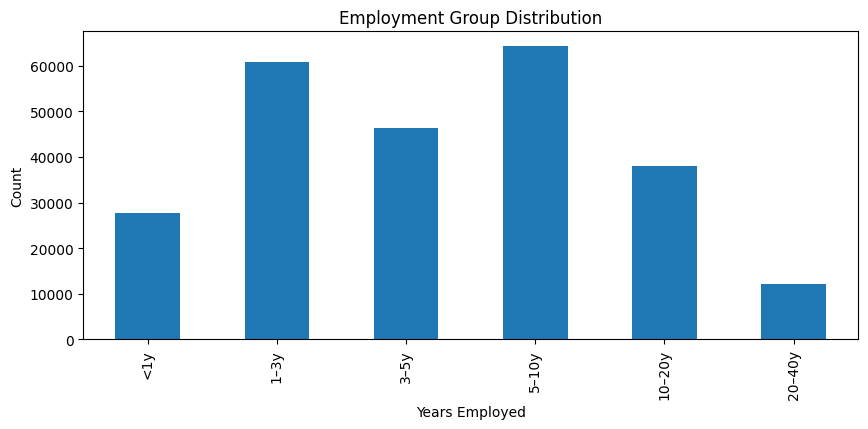

In [85]:
df['EMPLOYED_YEARS'] = abs(df['DAYS_EMPLOYED']) / 365

emp_bins = [0, 1, 3, 5, 10, 20, 40]
emp_labels = ['<1y', '1–3y', '3–5y', '5–10y', '10–20y', '20–40y']

df['EMPLOYMENT_GROUP'] = pd.cut(df['EMPLOYED_YEARS'], bins=emp_bins, labels=emp_labels)

print(df[['AGE_YEARS', 'AGE_GROUP', 'EMPLOYED_YEARS', 'EMPLOYMENT_GROUP']].head())

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
df['EMPLOYMENT_GROUP'].value_counts().sort_index().plot(kind='bar')
plt.title('Employment Group Distribution')
plt.xlabel('Years Employed')
plt.ylabel('Count')
plt.show()

* From the plots bellow, we can infer that people with less education, younger age, and shorter job history are more likely to have trouble repaying loans. Most borrowers share similar traits (like housing and job types), but defaults are more common among lower-income, early-career, and less-educated groups — showing how income, education, and job stability affect credit behavior.

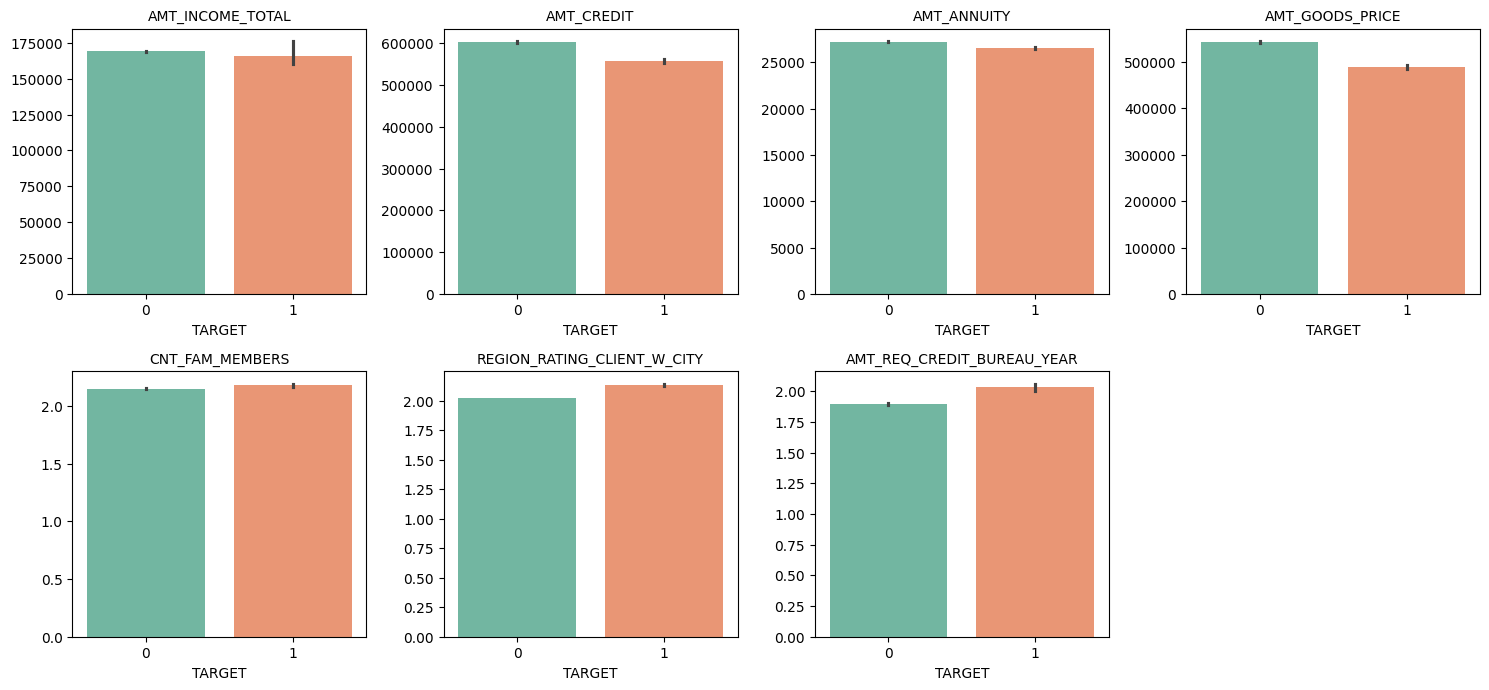

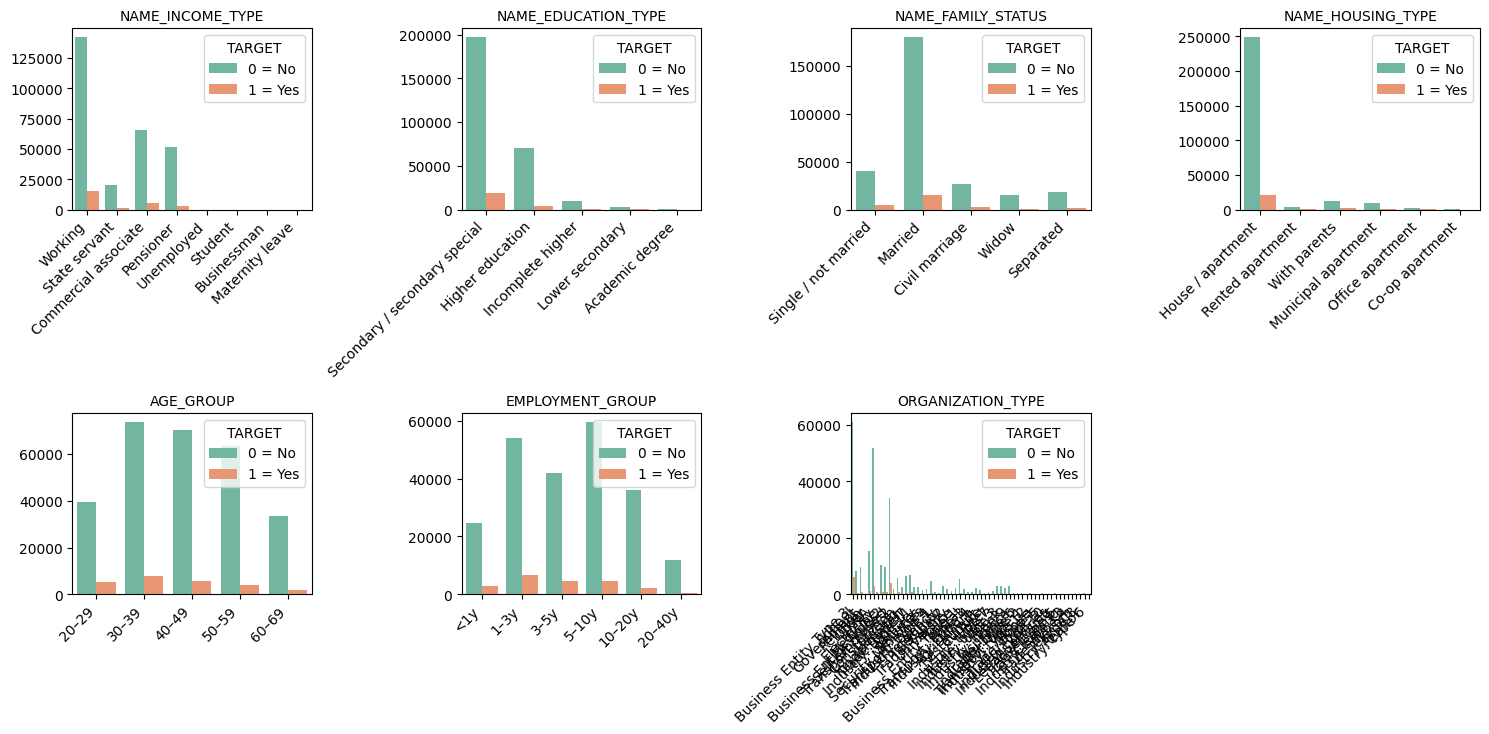

In [86]:
cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
        'NAME_HOUSING_TYPE', 'AGE_GROUP', 'EMPLOYMENT_GROUP',
        'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY',
        'ORGANIZATION_TYPE', 'AMT_REQ_CREDIT_BUREAU_YEAR']

num_cols = df[cols].select_dtypes(include=['number']).columns
cat_cols = df[cols].select_dtypes(exclude=['number']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.barplot(
    x='TARGET',
    y=col,
    hue='TARGET',
    data=df,
    palette='Set2',
    estimator='mean',
    legend=False
)

    plt.title(col, fontsize=10)
    plt.xlabel('TARGET')
    plt.ylabel('')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 4, i)
    sns.countplot(x=col, hue='TARGET', data=df, palette='Set2')
    plt.title(col, fontsize=10)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='TARGET', labels=['0 = No', '1 = Yes'])
plt.tight_layout()
plt.show()

2) Distribution and Outlier Detection

Created subplots of the same selected columns to check their distributions to see if there is a need for trimming outliers or binning.

Numeric columns: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', '

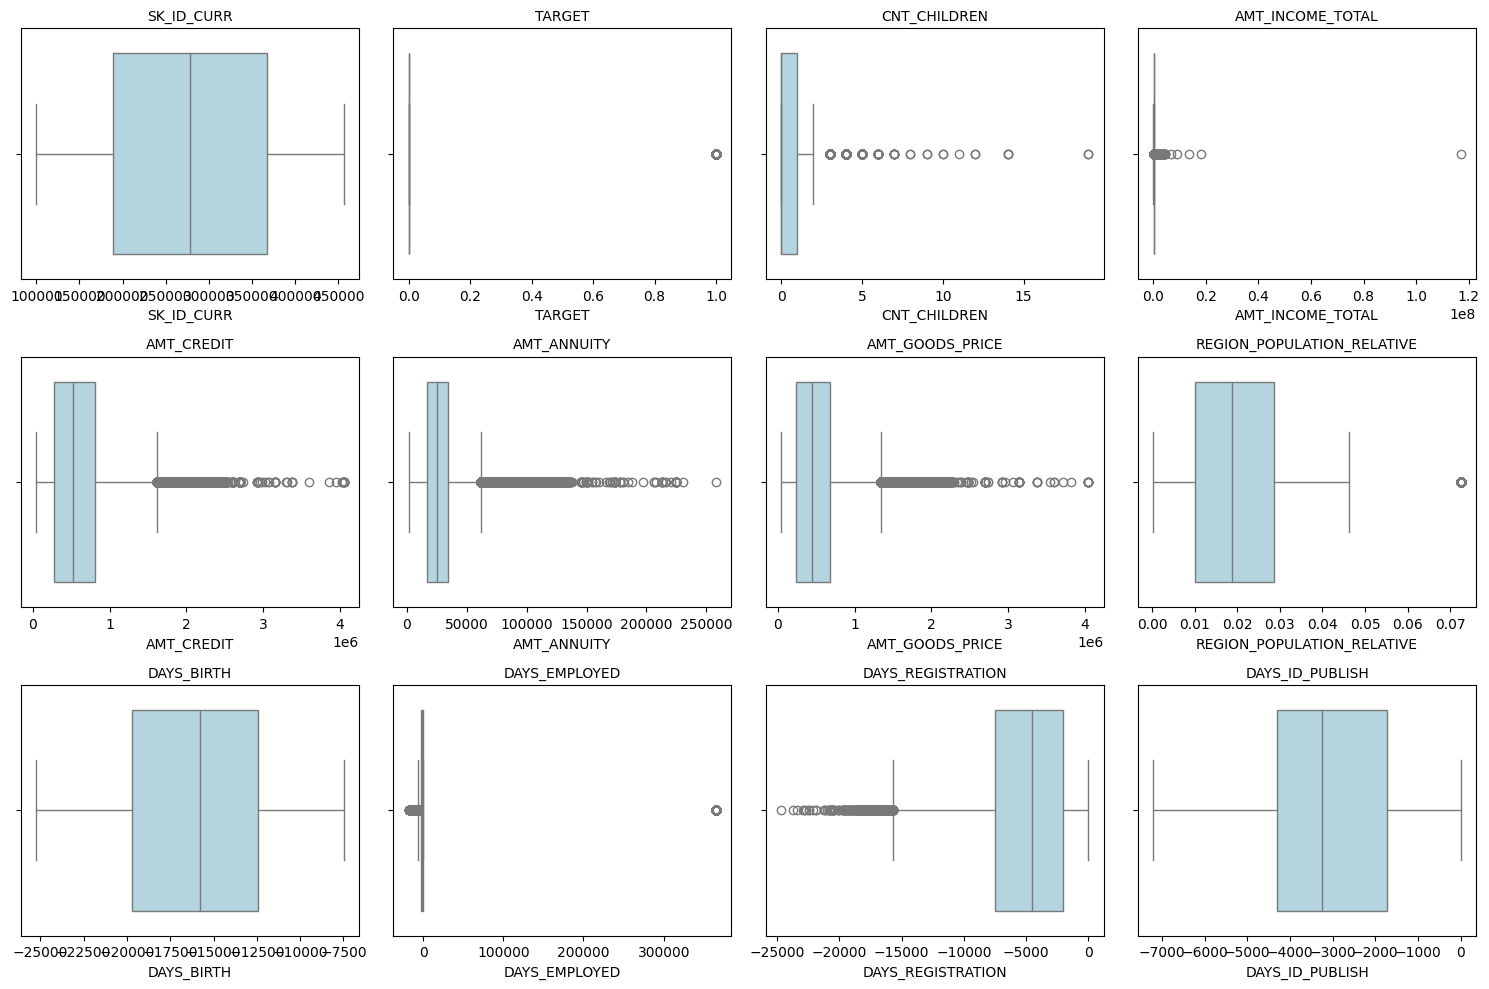

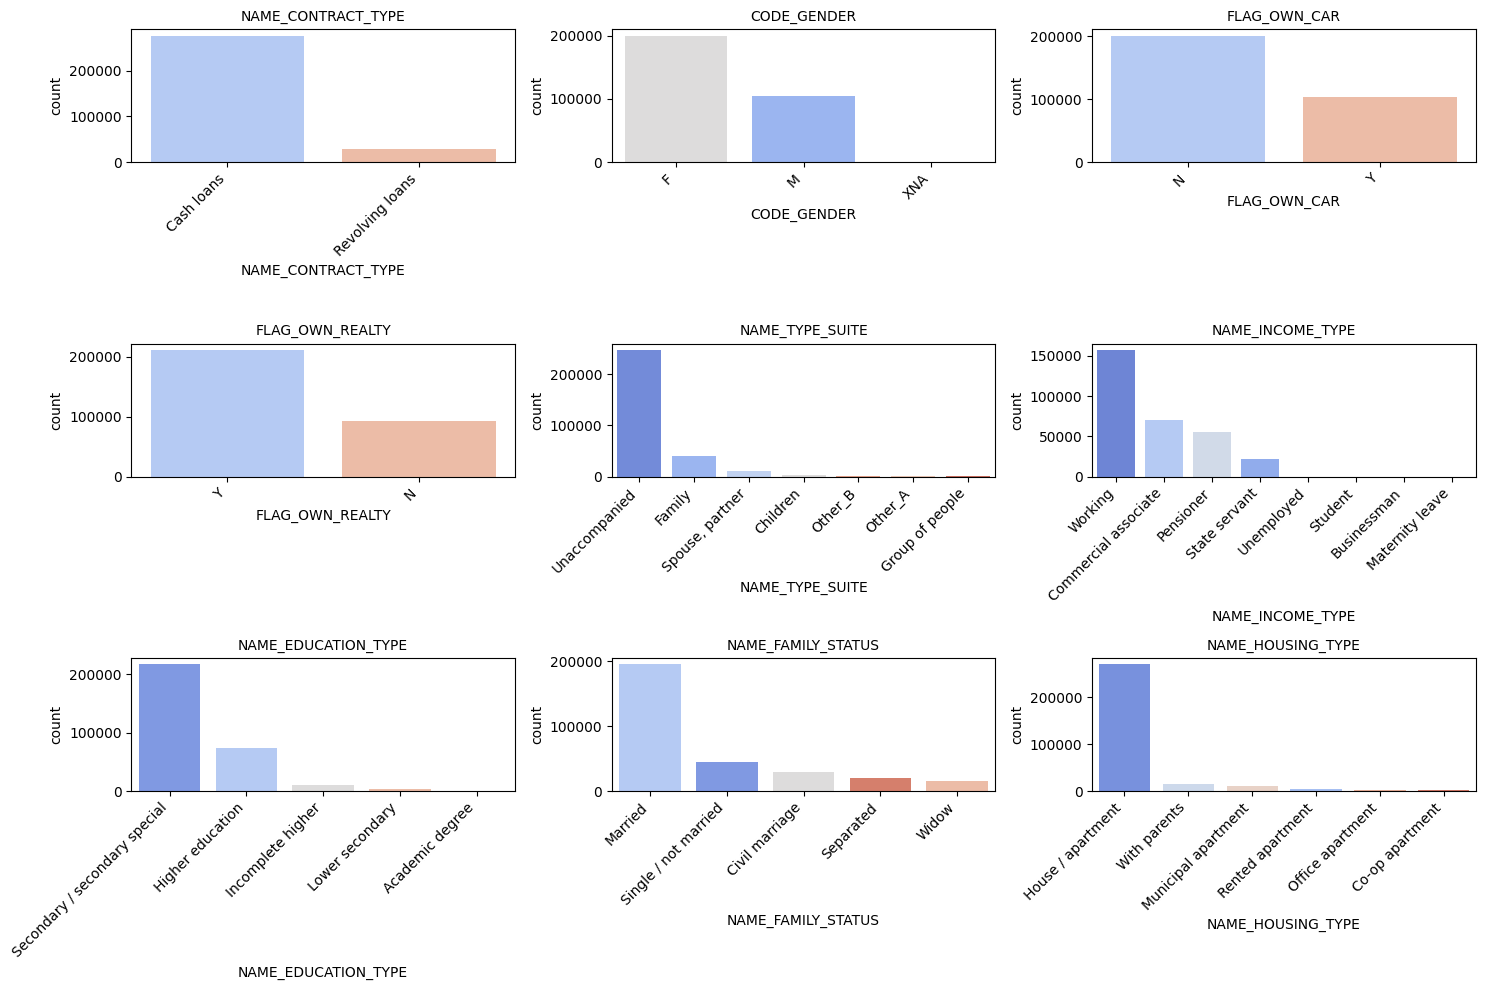

In [87]:

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns

print("Numeric columns:", list(num_cols))
print("Categorical columns:", list(cat_cols))

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols[:12], 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(col, fontsize=10)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols[:9], 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=col, hue=col, data=df, order=df[col].value_counts().index, palette="coolwarm", legend=False)

    plt.title(col, fontsize=10)
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Categorical columns - Grouped rare categories:
NAME_INCOME_TYPE: group very small categories (e.g., Maternity leave, Unemployed, Student) into 'Other_income'.

NAME_EDUCATION_TYPE: group very rare values (e.g., Academic degree, Lower secondary) into 'Other_edu'.

NAME_HOUSING_TYPE: group less common housing types (e.g., Rented apartment, Municipal apartment, With parents) into 'Other_housing'.

NAME_TYPE_SUITE: keep main categories (Unaccompanied, Family) and group the rest into 'Other_suite'.

CODE_GENDER: replace the rare 'XNA' value with the most frequent gender (usually 'F') because 'XNA' means “Not Available” or missing/unknown in the dataset.



In [88]:
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace(
    {'Maternity leave': 'Other_income',
     'Unemployed': 'Other_income',
     'Student': 'Other_income'}
)

df['NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].replace(
    {'Academic degree': 'Other_edu', 'Lower secondary': 'Other_edu'}
)

df['NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].replace(
    {'Rented apartment': 'Other_housing',
     'Municipal apartment': 'Other_housing',
     'With parents': 'Other_housing',
     'Co-op apartment': 'Other_housing'}
)

keep = {'Unaccompanied', 'Family'}
df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].where(df['NAME_TYPE_SUITE'].isin(keep), 'Other_suite')

mode_gender = df['CODE_GENDER'].mode()[0]
df['CODE_GENDER'] = df['CODE_GENDER'].replace({'XNA': mode_gender})

In [89]:
print(df['NAME_INCOME_TYPE'].unique())
print(df['NAME_EDUCATION_TYPE'].unique())
print(df['NAME_HOUSING_TYPE'].unique())
print(df['NAME_TYPE_SUITE'].unique())
print(df['CODE_GENDER'].unique())

['Working' 'State servant' 'Commercial associate' 'Pensioner'
 'Other_income' 'Businessman']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Other_edu']
['House / apartment' 'Other_housing' 'Office apartment']
['Unaccompanied' 'Family' 'Other_suite']
['M' 'F']


###IV - Outlier Treatment:

1) IQR Method Used to detect and remove extreme outliers that fall far outside the middle 50%. Columns: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED'].

In [90]:
num_cols = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
             'AMT_GOODS_PRICE', 'DAYS_EMPLOYED']

print("Initial dataset shape:", df.shape)

initial_rows = len(df)

limits = {}
for col in num_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    limits[col] = (lower, upper)

for col, (lower, upper) in limits.items():
    df = df[(df[col] >= lower) & (df[col] <= upper)]

final_rows = len(df)
removed_rows = initial_rows - final_rows
print(f"✅ After IQR outlier removal: {df.shape}  |  Rows removed: {removed_rows} ({removed_rows/initial_rows:.2%})")


Initial dataset shape: (304531, 76)
✅ After IQR outlier removal: (210065, 76)  |  Rows removed: 94466 (31.02%)


2) Winsorization Used to cap the impact of extreme but valid high values (≈5%) without removing records — helps maintain a stable and balanced data distribution. Columns: ['AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE'].

✅ Winsorization applied (≈1% each tail)


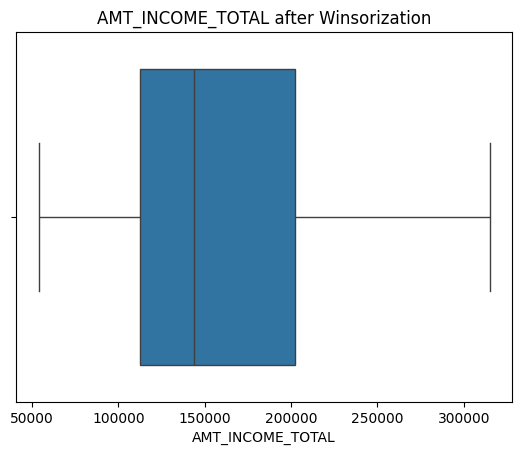

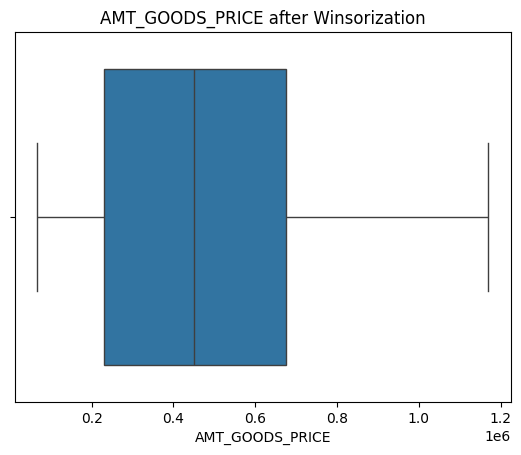

In [91]:
df['AMT_INCOME_TOTAL'] = np.asarray(
    winsorize(df['AMT_INCOME_TOTAL'], limits=[0.01, 0.01])
)
df['AMT_GOODS_PRICE'] = np.asarray(
    winsorize(df['AMT_GOODS_PRICE'], limits=[0.01, 0.01])
)

print("✅ Winsorization applied (≈1% each tail)")

# Quick visual check
sns.boxplot(x=df['AMT_INCOME_TOTAL'])
plt.title("AMT_INCOME_TOTAL after Winsorization")
plt.show()

sns.boxplot(x=df['AMT_GOODS_PRICE'])
plt.title("AMT_GOODS_PRICE after Winsorization")
plt.show()


###V. Feature Engineering:

1) Drop Index Column:

In [92]:
df.drop(columns=['SK_ID_CURR'], inplace=True)

In [93]:
'SK_ID_CURR' in df.columns

False

2. Train-Test Split

In [94]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (210065, 74)
y shape: (210065,)


In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [96]:
print("✅ Train–Test split complete:")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Class balance in y_train:\n", y_train.value_counts(normalize=True).round(3))
print("Class balance in y_test:\n", y_test.value_counts(normalize=True).round(3))

✅ Train–Test split complete:
Train shape: (168052, 74)
Test shape: (42013, 74)
Class balance in y_train:
 TARGET
0    0.906
1    0.094
Name: proportion, dtype: float64
Class balance in y_test:
 TARGET
0    0.906
1    0.094
Name: proportion, dtype: float64


3. Imputation to deal with the columns that with data 5–30% missing(X_train only):

In [97]:
missing_percent = X_train.isna().mean() * 100
mid_missing_cols = missing_percent[(missing_percent >= 5) & (missing_percent <= 30)].index

print(f"Columns to impute (5–30% missing): {len(mid_missing_cols)}")
print(list(mid_missing_cols))

Columns to impute (5–30% missing): 7
['EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [98]:
num_impute_cols = [c for c in mid_missing_cols if pd.api.types.is_numeric_dtype(X_train[c])]
cat_impute_cols = [c for c in mid_missing_cols if not pd.api.types.is_numeric_dtype(X_train[c])]



3.1) Impute numeric with median

In [99]:
if num_impute_cols:
    num_imp = SimpleImputer(strategy='median')
    X_train[num_impute_cols] = num_imp.fit_transform(X_train[num_impute_cols])
    X_test[num_impute_cols]  = num_imp.transform(X_test[num_impute_cols])

3.2) Impute categorical with most frequent value

In [100]:
if cat_impute_cols:
    cat_imp = SimpleImputer(strategy='most_frequent')
    X_train[cat_impute_cols] = cat_imp.fit_transform(X_train[cat_impute_cols])
    X_test[cat_impute_cols]  = cat_imp.transform(X_test[cat_impute_cols])

In [101]:
print(X_train[mid_missing_cols].isna().sum())

EXT_SOURCE_3                  0
AMT_REQ_CREDIT_BUREAU_HOUR    0
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
dtype: int64


4. Encode categorical columns(X_train only):   

In [102]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", list(cat_cols))

Categorical columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'AGE_GROUP', 'EMPLOYMENT_GROUP']


In [103]:
for col in cat_cols:
    print(f"\n{col}:", df[col].unique())


NAME_CONTRACT_TYPE: ['Cash loans' 'Revolving loans']

CODE_GENDER: ['M' 'F']

FLAG_OWN_CAR: ['N' 'Y']

FLAG_OWN_REALTY: ['Y' 'N']

NAME_TYPE_SUITE: ['Unaccompanied' 'Family' 'Other_suite']

NAME_INCOME_TYPE: ['Working' 'State servant' 'Commercial associate' 'Other_income'
 'Pensioner' 'Businessman']

NAME_EDUCATION_TYPE: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Other_edu']

NAME_FAMILY_STATUS: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated']

NAME_HOUSING_TYPE: ['House / apartment' 'Other_housing' 'Office apartment']

WEEKDAY_APPR_PROCESS_START: ['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY' 'SUNDAY']

ORGANIZATION_TYPE: ['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Kindergarten' 'Trade: type 7'
 'Industry: type 11' 'Military' 'Services' 'Security Ministries'
 'Transport: type 4' 'Industry: 

In [104]:
ordinal_cols = ['AGE_GROUP', 'EMPLOYMENT_GROUP', 'NAME_EDUCATION_TYPE']
nominal_cols = [col for col in cat_cols if col not in ordinal_cols]

print("Ordinal columns:", ordinal_cols)
print("Nominal columns:", nominal_cols)

Ordinal columns: ['AGE_GROUP', 'EMPLOYMENT_GROUP', 'NAME_EDUCATION_TYPE']
Nominal columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']


4.1) Ordinal Encoding for ordinal columns

In [105]:
ord_enc = OrdinalEncoder()
X_train[ordinal_cols] = ord_enc.fit_transform(X_train[ordinal_cols])
X_test[ordinal_cols]  = ord_enc.transform(X_test[ordinal_cols])

4.2) One-Hot encoding for non-ordinal columns

In [106]:

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[nominal_cols]),
                           columns=ohe.get_feature_names_out(nominal_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(ohe.transform(X_test[nominal_cols]),
                          columns=ohe.get_feature_names_out(nominal_cols),
                          index=X_test.index)


X_train = X_train.drop(columns=nominal_cols).join(X_train_ohe)
X_test  = X_test.drop(columns=nominal_cols).join(X_test_ohe)

print("Encoding complete! X_train shape:", X_train.shape)

Encoding complete! X_train shape: (168052, 153)


5. Scaling (X_train only- Fit on X_train, Transform on X_test): StandardScaler → for PCA later

In [107]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [108]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

print("✅ Scaling complete!")

✅ Scaling complete!


In [109]:
print("Before scaling:")
print(X_train.describe().T[['mean', 'std']].head())

print("\nAfter scaling:")
print(X_train_scaled.describe().T[['mean', 'std']].head())

Before scaling:
                           mean            std
CNT_CHILDREN           0.515102       0.773013
AMT_INCOME_TOTAL  156367.482738   61429.147163
AMT_CREDIT        538714.353867  319445.754392
AMT_ANNUITY        25337.487650   11509.197499
AMT_GOODS_PRICE   478950.850763  282836.796569

After scaling:
                          mean       std
CNT_CHILDREN      1.902651e-18  1.000003
AMT_INCOME_TOTAL -1.050052e-16  1.000003
AMT_CREDIT        1.596535e-16  1.000003
AMT_ANNUITY       1.365680e-16  1.000003
AMT_GOODS_PRICE   4.583274e-17  1.000003


6. Dimensionality Reduction - PCA(X_train only- Fit on X_train, Transform on X_test):

6.1) Find the Best Number of Components for PCA: Plot the Explained Variance Curve

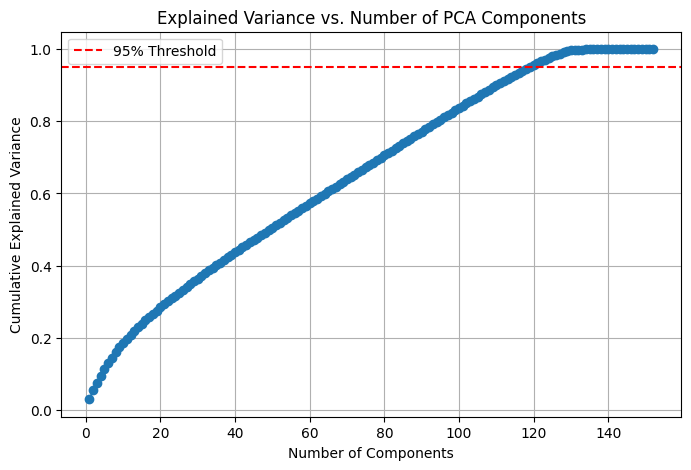

In [110]:
X_train_scaled_numeric = X_train_scaled.select_dtypes(include=np.number).drop(columns=['EMPLOYMENT_GROUP'], errors='ignore')

pca = PCA().fit(X_train_scaled_numeric)

cum_var = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', linestyle='--')
plt.title("Explained Variance vs. Number of PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.legend()
plt.show()

In [111]:
n_components_95 = np.argmax(cum_var >= 0.95) + 1
print(f"Number of components to keep 95% variance: {n_components_95}")

Number of components to keep 95% variance: 119


6.2) Apply PCA Using the found best number of components

In [112]:
# Select only numeric columns from the scaled data for PCA and drop 'EMPLOYMENT_GROUP'
X_train_scaled_numeric = X_train_scaled.select_dtypes(include=np.number).drop(columns=['EMPLOYMENT_GROUP'])
X_test_scaled_numeric = X_test_scaled.select_dtypes(include=np.number).drop(columns=['EMPLOYMENT_GROUP'])

pca = PCA(n_components=n_components_95, svd_solver='full', random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled_numeric)
X_test_pca  = pca.transform(X_test_scaled_numeric)

7. Target Class Balancing (SMOTE on X_train only)

In [113]:
class_counts = y_train.value_counts()
print(class_counts)

TARGET
0    152285
1     15767
Name: count, dtype: int64


In [114]:
class_percent = (class_counts / len(y_train)) * 100
print(class_percent)

TARGET
0    90.617785
1     9.382215
Name: count, dtype: float64


/tmp/ipython-input-412706936.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='pastel')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


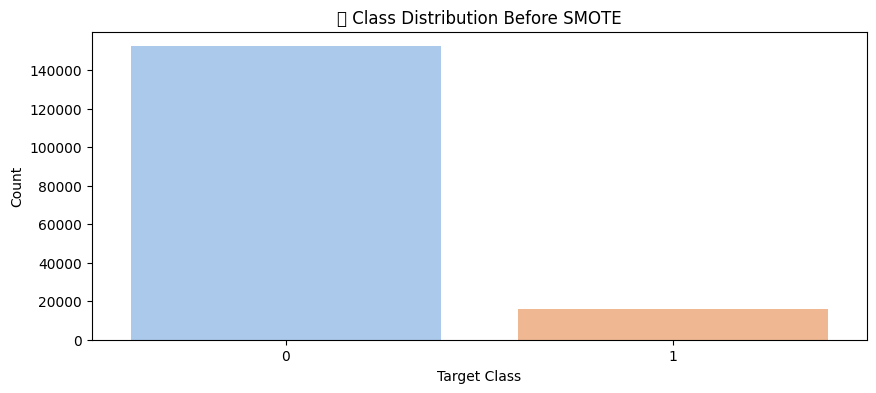

In [115]:
plt.figure(figsize=(10,4))
sns.countplot(x=y_train, palette='pastel')
plt.title("🔹 Class Distribution Before SMOTE")
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.show()

In [116]:
print("Before:", Counter(y_train))

smote = SMOTE(sampling_strategy=0.8, k_neighbors=3, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_pca, y_train)

print("After:", Counter(y_train_bal))



Before: Counter({0: 152285, 1: 15767})
After: Counter({0: 152285, 1: 121828})


In [117]:
print((y_train_bal.value_counts(normalize=True)*100).round(2))

TARGET
0    55.56
1    44.44
Name: proportion, dtype: float64


/tmp/ipython-input-2164727964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_bal, palette='pastel')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


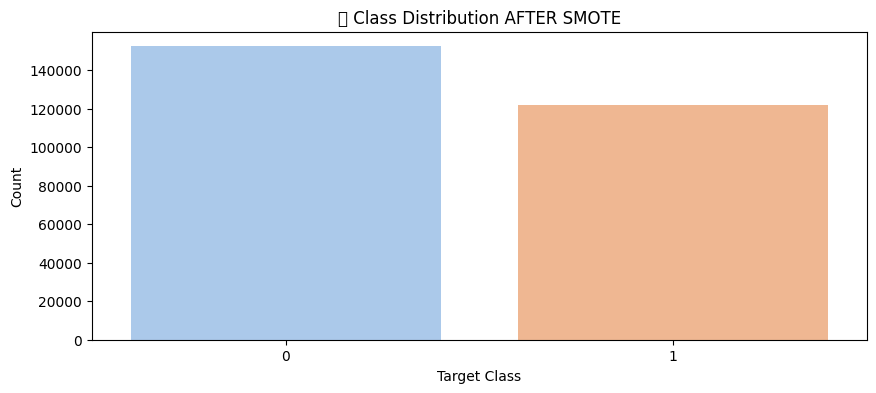

In [118]:
plt.figure(figsize=(10,4))
sns.countplot(x=y_train_bal, palette='pastel')
plt.title("🔹 Class Distribution AFTER SMOTE")
plt.xlabel("Target Class")
plt.ylabel("Count")
plt.show()

#**Step 2: Model Building, Testing and Evaluating:**

###I- Import necessary libraries:

In [144]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import (
    classification_report, confusion_matrix, precision_recall_curve,
    roc_curve, auc, roc_auc_score, precision_score, recall_score,
    f1_score, accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
)

import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import PrecisionRecallDisplay


II- Split balanced training data into train + validation:

In [120]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_bal, y_train_bal,
    test_size=0.20,
    random_state=42,
    stratify=y_train_bal
)

III-Get Number of Input Features:

In [121]:
n_features = X_train_sub.shape[1]
print("n_features:", n_features)

n_features: 119


IV-Model Architecture Plan

In [122]:
model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.20),

    layers.Dense(48, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.15),

    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 96)             │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,553 (68.57 KB)

 Trainable params: 17,265 (67.44 KB)

 Non-trainable params: 288 (1.12 KB)

V-Compile

In [123]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc_pr', curve='PR'),
        keras.metrics.AUC(name='auc_roc', curve='ROC')
    ]
)

VI-Callbacks

In [124]:
early_stop = callbacks.EarlyStopping(
    monitor='val_auc_pr', mode='max',
    patience=5, restore_best_weights=True
)


VII-Train The Model

In [125]:
history = model.fit(
    X_train_sub, y_train_sub,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/70
857/857 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6660 - auc_pr: 0.6443 - auc_roc: 0.7207 - loss: 0.6270 - precision: 0.6299 - recall: 0.5913 - val_accuracy: 0.7273 - val_auc_pr: 0.7433 - val_auc_roc: 0.8012 - val_loss: 0.5553 - val_precision: 0.6801 - val_recall: 0.7296
Epoch 2/70
857/857 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7237 - auc_pr: 0.7347 - auc_roc: 0.7949 - loss: 0.5596 - precision: 0.6876 - recall: 0.6929 - val_accuracy: 0.7487 - val_auc_pr: 0.7744 - val_auc_roc: 0.8247 - val_loss: 0.5275 - val_precision: 0.7114 - val_recall: 0.7313
Epoch 3/70
857/857 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7412 - auc_pr: 0.7623 - auc_roc: 0.8157 - loss: 0.5360 - precision: 0.7087 - recall: 0.7100 - val_accuracy: 0.7624 - val_auc_pr: 0.7945 - val_auc_roc: 0.8398 - val_loss: 0.5084 - val_precision: 0.7141 - val_recall: 0.7762
Epoch 4/70
857/857 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7523 - auc_pr: 0.7793 - auc_roc: 0.8276 - loss: 0.5212 - precision: 0

In [126]:
print(sorted(history.history.keys()))

['accuracy', 'auc_pr', 'auc_roc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc_pr', 'val_auc_roc', 'val_loss', 'val_precision', 'val_recall']


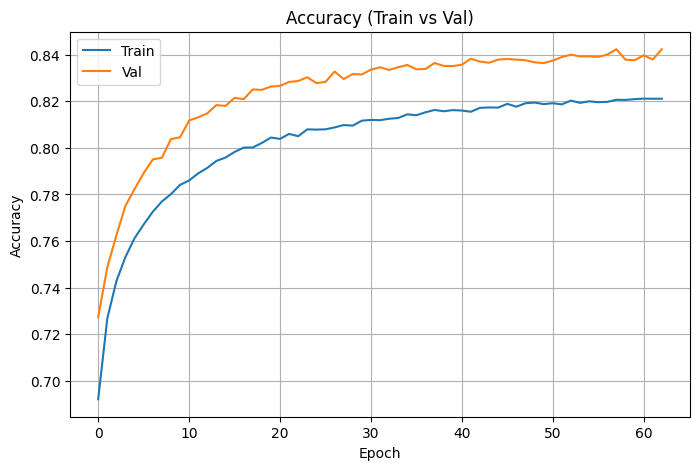

In [127]:
plt.figure(figsize=(8,5)); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Val'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy (Train vs Val)'); plt.legend(); plt.grid(True); plt.show()

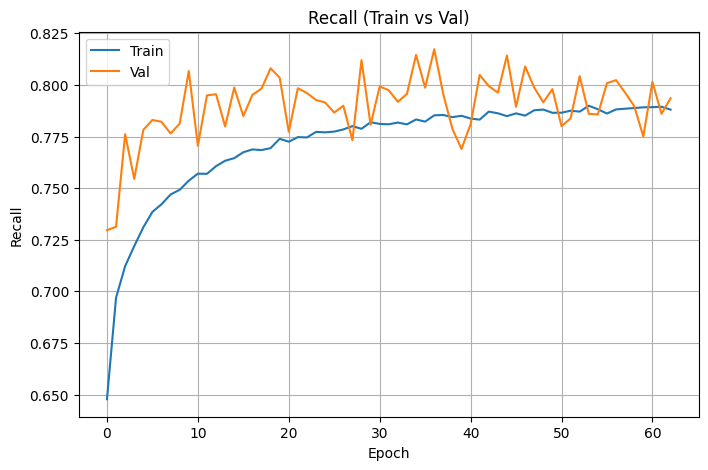

In [128]:
plt.figure(figsize=(8,5)); plt.plot(history.history['recall'], label='Train'); plt.plot(history.history['val_recall'], label='Val'); plt.xlabel('Epoch'); plt.ylabel('Recall'); plt.title('Recall (Train vs Val)'); plt.legend(); plt.grid(True); plt.show()

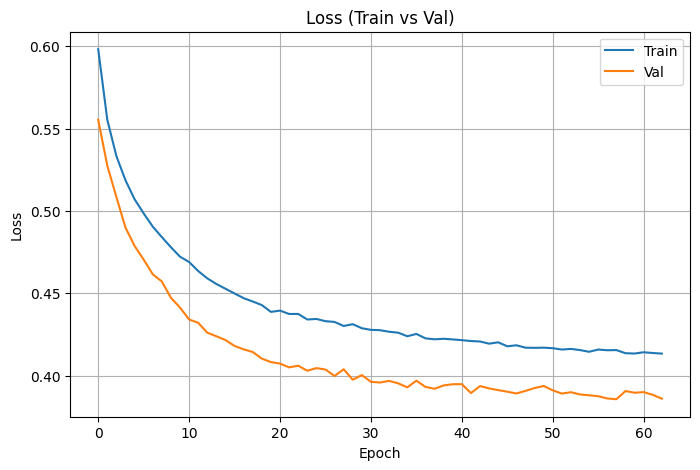

In [129]:
plt.figure(figsize=(8,5)); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss (Train vs Val)'); plt.legend(); plt.grid(True); plt.show()

 ***TRAINING-SET PERFORMANCE:**.

Learning is steady: Training loss goes down smoothly; nothing weird in the curve.

Not memorizing: L2 + Dropout + BatchNorm help the model learn patterns, not just the data by heart.

Focused on the minority class: Training recall and PR-AUC improve—good for catching defaulters in an imbalanced dataset.

Looks healthy: Training and validation curves are close; no big gaps.
   


VIII- Evaluation on Validation Set

8.1) Evaluate Compiled Metrics

In [130]:
val_metrics = model.evaluate(X_val, y_val, verbose=0)
val_results = dict(zip(model.metrics_names, val_metrics))
print("Validation metrics:", val_results)


Validation metrics: {'loss': 0.3856706917285919, 'compile_metrics': 0.8423654437065125}


8.2) Predict Probabilities on Validation Set

In [131]:
y_val_proba = model.predict(X_val, verbose=0).ravel()

print('First 5 predicted probabilities on the validation set:')
print(y_val_proba[:5])

First 5 predicted probabilities on the validation set:
[0.04481243 0.38874835 0.29651678 0.00108902 0.9055585 ]


8.3)  Apply Default Threshold (0.5)

In [132]:
y_val_pred = (y_val_proba >= 0.5).astype(int)

8.4) Classification Report & Confusion Matrix

In [133]:
print(f"Validation AUC (ROC): {roc_auc_score(y_val, y_val_proba):.3f}")
print("Classification Report:\n", classification_report(y_val, y_val_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))


Validation AUC (ROC): 0.919
Classification Report:
               precision    recall  f1-score   support

           0      0.844     0.879     0.861     30457
           1      0.841     0.796     0.818     24366

    accuracy                          0.842     54823
   macro avg      0.842     0.838     0.839     54823
weighted avg      0.842     0.842     0.842     54823

Confusion Matrix:
 [[26779  3678]
 [ 4964 19402]]


 **VALIDATION-SET PERFORMANCE:**.  
  
Generalizes well: Validation curves follow training curves - no clear overfitting.

Best checkpoint kept: We stop at the epoch with the highest val PR-AUC (best at finding defaulters).

Choose a threshold: From validation probabilities we pick a cutoff that gives the recall we want, knowing precision will drop some.

Expected trade-off: Lowering the cutoff raises TP (more defaulters caught) and also FP (more safe borrowers flagged).

IX – Generate Predictions & Evaluate on Test Set

9.1) Evaluate Compiled Metrics

In [134]:
test_metrics = model.evaluate(X_test_pca, y_test, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))


Test metrics: {'loss': 0.41394370794296265, 'compile_metrics': 0.8257206082344055}


9.2) Predict Probabilities

In [135]:
y_test_proba = model.predict(X_test_pca, verbose=0).ravel()
print('First 5 predicted probabilities on the test set:')
print(y_test_proba[:5])

First 5 predicted probabilities on the test set:
[0.04836385 0.40165102 0.06458849 0.21639866 0.35166612]


9.3) Convert Probabilities to Class Labels

In [136]:
base_threshold = 0.5
y_test_pred = (y_test_proba >= base_threshold).astype(int)
print("Default threshold (0.5) results:")
print(classification_report(y_test, y_test_pred, digits=3))
print(confusion_matrix(y_test, y_test_pred))


Default threshold (0.5) results:
              precision    recall  f1-score   support

           0      0.924     0.880     0.901     38071
           1      0.208     0.305     0.247      3942

    accuracy                          0.826     42013
   macro avg      0.566     0.592     0.574     42013
weighted avg      0.857     0.826     0.840     42013

[[33488  4583]
 [ 2739  1203]]


**Adjust threshold:**

In [137]:
threshold = 0.45
y_test_pred = (y_test_proba >= threshold).astype(int)
print(f"\nEvaluation at threshold = {threshold}")
print(classification_report(y_test, y_test_pred, digits=3))
print(confusion_matrix(y_test, y_test_pred))


Evaluation at threshold = 0.45
              precision    recall  f1-score   support

           0      0.927     0.854     0.889     38071
           1      0.200     0.354     0.256      3942

    accuracy                          0.807     42013
   macro avg      0.564     0.604     0.573     42013
weighted avg      0.859     0.807     0.830     42013

[[32498  5573]
 [ 2545  1397]]


9.4) Classification Report

In [138]:
print("Classification Report:\n", classification_report(y_test, y_test_pred, digits=3))


Classification Report:
               precision    recall  f1-score   support

           0      0.927     0.854     0.889     38071
           1      0.200     0.354     0.256      3942

    accuracy                          0.807     42013
   macro avg      0.564     0.604     0.573     42013
weighted avg      0.859     0.807     0.830     42013



9.5) Confusion Matrix (Test)

Confusion Matrix:
 [[32498  5573]
 [ 2545  1397]]


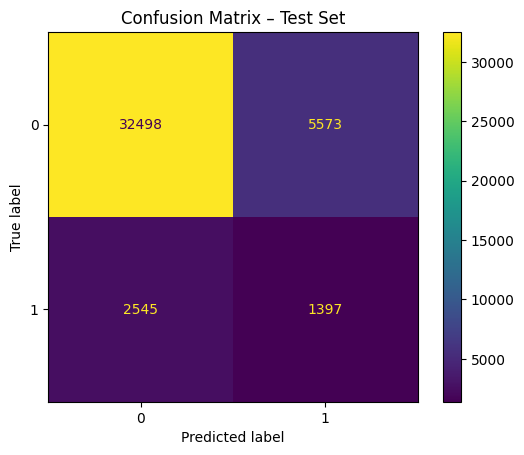

In [139]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Confusion Matrix – Test Set")
plt.show()

9.6) ROC–AUC Score (Test)

In [140]:
print(f"ROC–AUC Score: {roc_auc_score(y_test, y_test_proba):.3f}")


ROC–AUC Score: 0.688


9.7) Precision–Recall Curve (Test)





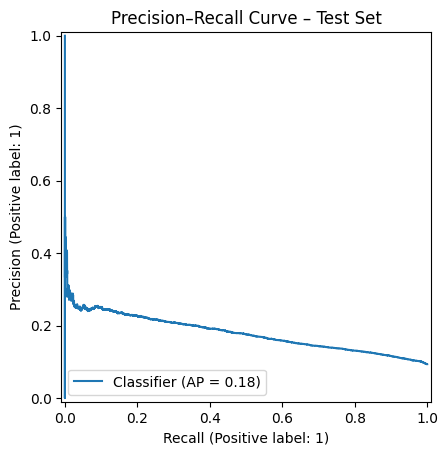

In [145]:
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision–Recall Curve – Test Set")
plt.show()

9.8) ROC–AUC Curve (Visualization) (Test)

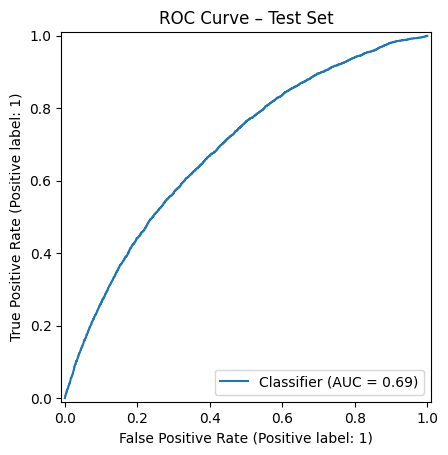

In [146]:
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve – Test Set")
plt.show()


9.9) Sensitivity / Recall Analysis (Threshold Study)

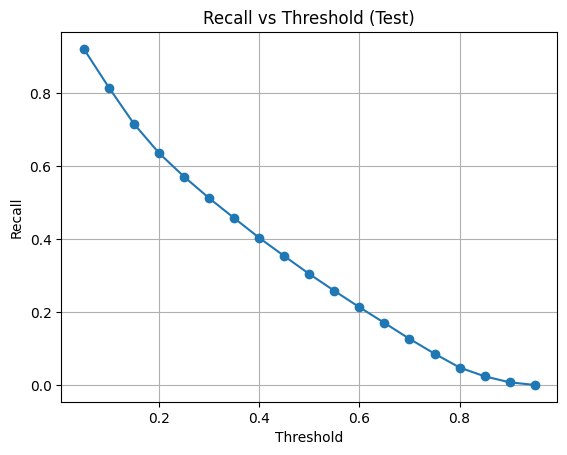

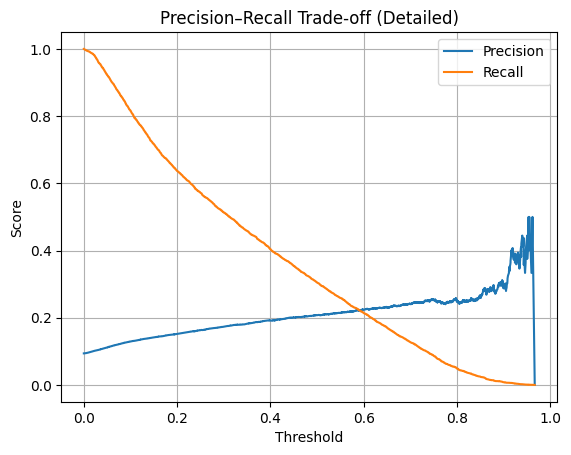

In [147]:
thresholds = np.linspace(0.05, 0.95, 19)
recalls = [recall_score(y_test, (y_test_proba >= t).astype(int)) for t in thresholds]
plt.plot(thresholds, recalls, marker='o')
plt.title('Recall vs Threshold (Test)')
plt.xlabel('Threshold'); plt.ylabel('Recall'); plt.grid(True); plt.show()

precisions, recalls_curve, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
plt.plot(pr_thresholds, precisions[:-1], label='Precision')
plt.plot(pr_thresholds, recalls_curve[:-1], label='Recall')
plt.title('Precision–Recall Trade-off (Detailed)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


XI- Sensitivity (Recall / True Positive Rate)


**TEST-SET PERFORMANCE:**.  
Can separate classes:
The ROC-AUC score shows that the model can clearly tell apart borrowers who will repay from those who may default.
The PR-AUC (Precision-Recall AUC) is especially important here because the dataset is imbalanced — defaulters are rare. A higher PR-AUC means the model finds more true defaulters without creating too many false alarms.

Recall vs Precision:
When we raise recall, the model becomes more sensitive — it catches more real defaulters but may also flag more good clients by mistake.
Precision drops slightly because some of the flagged cases are not real defaulters.
This trade-off is acceptable in lending, since it is safer to review a few extra applicants than to approve someone who can not repay.

Confusion:

True Positives (TP)  — We are identifying more real defaulters correctly.

False Positives (FP)  — More safe borrowers are flagged for extra checks or manual review.

False Negatives (FN)  — Fewer defaulters slip through unnoticed, which is the main business goal.

Overall, the model favors catching more risky clients even if it means reviewing a few safe ones, reducing potential financial losses.



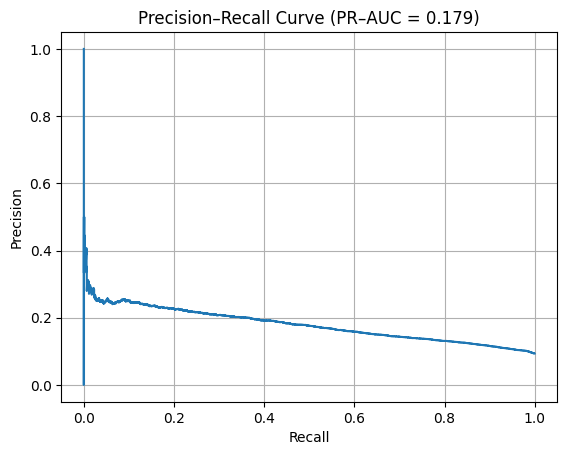

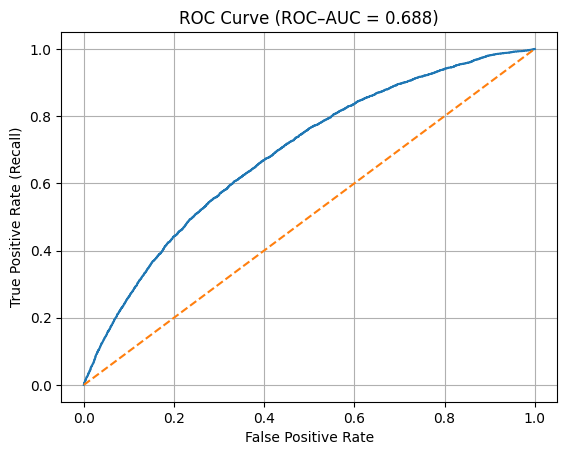

PR–AUC:  0.1787
ROC–AUC: 0.6879


In [148]:
prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(rec, prec)

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (PR–AUC = {pr_auc:.3f})")
plt.grid(True)
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve (ROC–AUC = {roc_auc:.3f})")
plt.grid(True)
plt.show()

print(f"PR–AUC:  {pr_auc:.4f}")
print(f"ROC–AUC: {roc_auc:.4f}")

#**Step 3: Save Model:**

In [150]:
model.save("loan_repayment_model.keras")

In [149]:

print(os.listdir())


['.config', 'drive', 'sample_data']


#**Step 4: Conclusion:**



Goal: In lending, it’s much worse to miss a real defaulter than to double-check a safe borrower.

Approach: We adjusted the decision threshold so the model focuses on recall — finding as many real defaulters as possible before loans are approved.

Trade-off: When recall goes up, precision drops a bit — meaning more safe applicants are flagged for review. But this is worth it, because catching extra defaulters saves more money than the cost of reviewing a few safe ones.

How we track performance: We monitor PR-AUC, recall, and the confusion matrix to see if the model is still doing its job. If too many safe borrowers get flagged, we can raise the threshold slightly or send borderline cases to manual review.

Bottom line: The chosen setup helps reduce loan losses by identifying high-risk clients early, while keeping the extra review work at a manageable level.